# Statistical Algos

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

INTERVAL = YFinanceOptions.M15
TARGET_FUT=WHEAT_FUT.replace("=F", "")

TARGET_FUT, INTERVAL

('ZW', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(3936, 114)
Index(['CL_Open', 'CL_High', 'CL_Low', 'CL_Close', 'CL_Volume', 'CL_Spread',
       'DC_Open', 'DC_High', 'DC_Low', 'DC_Close',
       ...
       'ZS_Low', 'ZS_Close', 'ZS_Volume', 'ZS_Spread', 'ZW_Open', 'ZW_High',
       'ZW_Low', 'ZW_Close', 'ZW_Volume', 'ZW_Spread'],
      dtype='object', length=114)


,CL_Open,CL_High,CL_Low,CL_Close,CL_Volume,CL_Spread,DC_Open,DC_High,DC_Low,DC_Close,...,ZS_Low,ZS_Close,ZS_Volume,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-20 22:16:00+00:00,81.07,81.129997,80.870003,81.019997,5918,0.259995,17.299999,18.040001,17.299999,18.040001,...,1208.75,1210.75,14397,7.25,548.5,551.75,546.75,549.5,4377,5.0
2024-03-20 22:31:00+00:00,81.07,81.129997,80.870003,81.019997,5918,0.259995,17.299999,18.040001,17.299999,18.040001,...,1208.75,1210.75,14397,7.25,548.5,551.75,546.75,549.5,4377,5.0


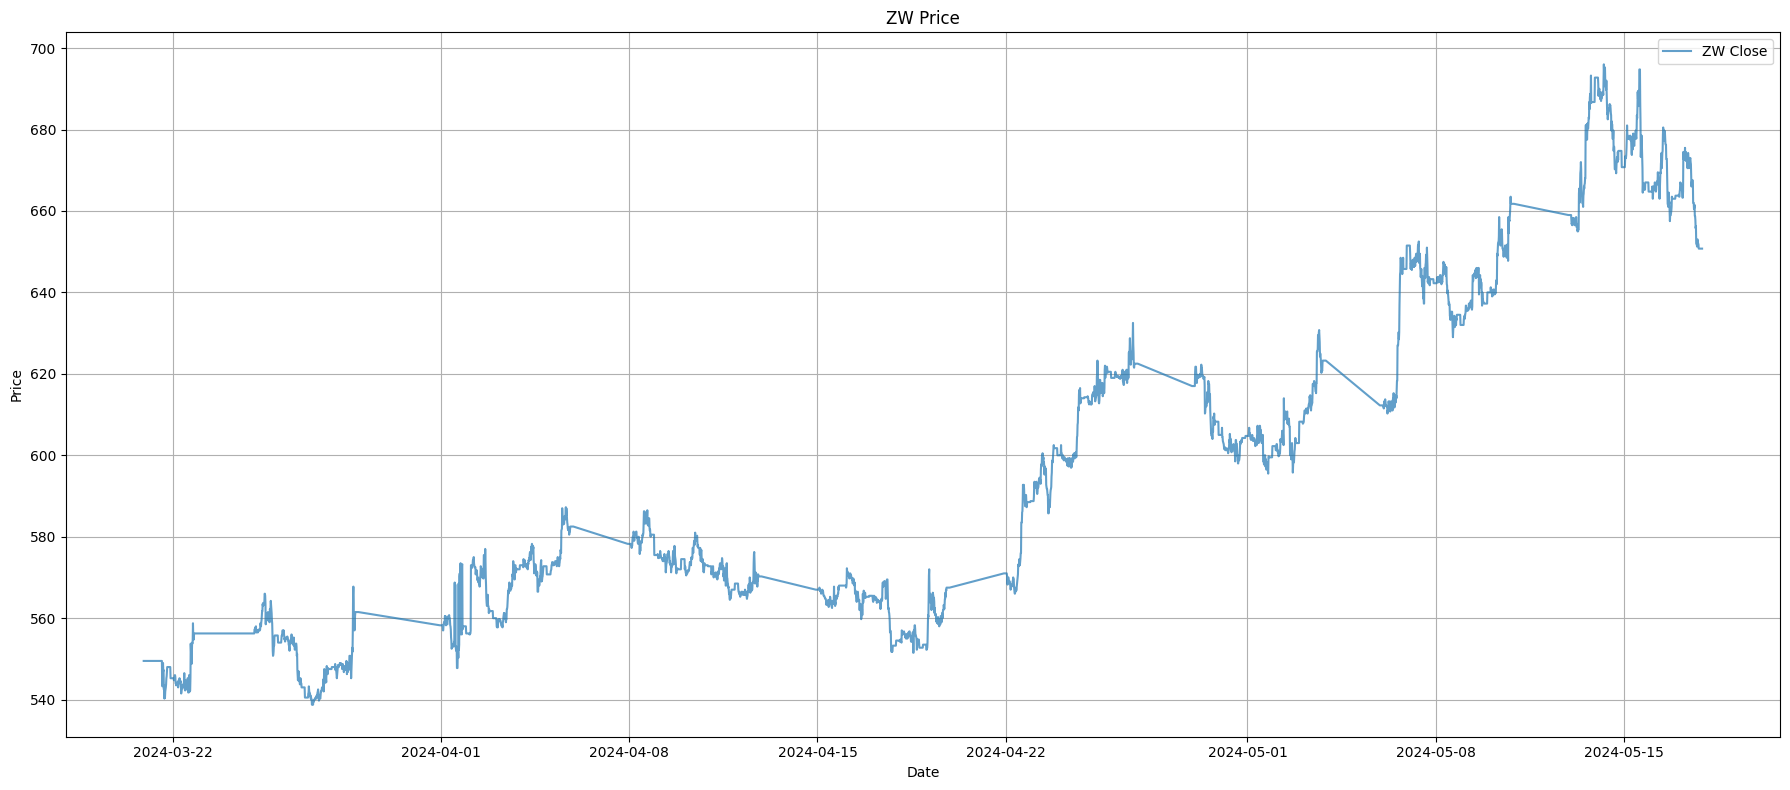

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Problem Defintion

Utilize meduim-frequency trade data for a set of 6 Future contracts listed on CME during a 250-day trading periods between 01/01/2023 and 01/01/2024. Future contracts are cross-sectional from metals, equities and volatiliyy. Trading is 23hours, with minute durations.

In [6]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close"]]
target_fut_df

,ZW_Close
Date,
2024-03-20 22:16:00+00:00,549.50
2024-03-20 22:31:00+00:00,549.50
2024-03-20 22:46:00+00:00,549.50
2024-03-20 23:01:00+00:00,549.50
2024-03-20 23:16:00+00:00,549.50
...,...
2024-05-17 21:01:00+00:00,650.75
2024-05-17 21:16:00+00:00,650.75
2024-05-17 21:31:00+00:00,650.75


In [7]:
from quant_equations import get_ou, get_annualized_factor, calc_annualized_sharpe, deflated_sharpe_ratio

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 887
Hurst: 0.5200025427246997


# Time Series Momentum

$$
\text{TSMOM}_i = \frac{P_i(t) - P_i(t - T)}{P_i(t - T)}
$$

where:

- \( P_i(t) \) is the current price of asset \( i \) at time \( t \).
- \( P_i(t - T) \) is the price of asset \( i \) at time \( t - T \).
- \( T \) is the look-back period.

https://www.sciencedirect.com/science/article/pii/S0304405X11002613

https://www.sciencedirect.com/science/article/pii/S1042443118303093

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2407199 

In [8]:
def get_tsmom_signals(prices, lookback, contra_lookback, std_threshold=2):
    def get_auto_covariance(returns, window):
        mean_returns = returns.rolling(window=window).mean()
        auto_cov = (returns - mean_returns).rolling(window=window).apply(lambda x: np.mean((x - x.mean()) * (x.shift(1) - x.shift(1).mean())))
        return auto_cov

    returns = prices.pct_change().fillna(0.)
    auto_cov = get_auto_covariance(returns, lookback).fillna(0.)

    signals = (1 * np.sign(auto_cov)).astype(int)
    rolling_std = prices.rolling(window=contra_lookback).std()
    contra_signal = (((signals > 0) & (rolling_std < -std_threshold)) | ((signals < 0) & (rolling_std > std_threshold))).astype(int)

    signals_df = pd.DataFrame({
        'TSMOM': signals,
        'CONTRA': contra_signal
    }, index=returns.index)

    return signals_df

tsmom_signals = get_tsmom_signals(target_fut_df[f"{TARGET_FUT}_Close"], lookback=abs(HALF_LIFE), contra_lookback=abs(HALF_LIFE)//2)
tsmom_signals

,TSMOM,CONTRA
Date,,
2024-03-20 22:16:00+00:00,0,0
2024-03-20 22:31:00+00:00,0,0
2024-03-20 22:46:00+00:00,0,0
2024-03-20 23:01:00+00:00,0,0
2024-03-20 23:16:00+00:00,0,0
...,...,...
2024-05-17 21:01:00+00:00,-1,1
2024-05-17 21:16:00+00:00,-1,1
2024-05-17 21:31:00+00:00,-1,1


## Datamining

In [9]:
from tqdm import tqdm
import itertools
import math
from scipy.stats import skew, kurtosis

def tsmom_backtest(df, target_col, lookback=abs(HALF_LIFE), contra_lookback=abs(HALF_LIFE//2), period=INTERVAL, std_threshold=1.5):
    df = df.copy()
    df['Closed'] = 0
    df['Position'] = 0
    df['Ret'] = 0.0
    ts_mom_df = get_tsmom_signals(df[target_col], lookback=lookback, contra_lookback=contra_lookback, std_threshold=std_threshold)
    df['TSMOM'] = ts_mom_df['TSMOM']
    df['CONTRA'] = ts_mom_df['CONTRA']

    df['TSMOM_Shifted'] = df['TSMOM'].shift(1).fillna(0)
    df['CONTRA_Shifted'] = df['CONTRA'].shift(3).fillna(0)
    df['SB'] = (df['TSMOM_Shifted'] > 0) & (df['CONTRA_Shifted'] == 0)
    df['SS'] = (df['TSMOM_Shifted'] < 0) & (df['CONTRA_Shifted'] == 0)
    df['SBS'] = df['TSMOM_Shifted'] < 1
    df['SSB'] = df['TSMOM_Shifted'] > -1

    entry = 0
    position = 0
    for i, row in df.iterrows():
        if (row['SBS'] and position == 1) or (row['SSB'] and position == -1):
            if position == 1:
                df.at[i, 'Ret'] = (row[target_col] - entry) / entry
                df.at[i, 'Closed'] = 1
            else:
                df.at[i, 'Ret'] = (entry - row[target_col]) / entry
                df.at[i, 'Closed'] = -1
            position = 0
        if row['SB'] and position == 0:
            entry = row[target_col]
            position = 1
        elif row['SS'] and position == 0:
            entry = row[target_col]
            position = -1
        if position !=0 and row['CONTRA'] != 0:
            position = -position

        df.at[i, 'Position'] = position

    df['Ret'] = df['Position'] * df[target_col].pct_change().fillna(0)
    df['cRets'] = (1 + df['Ret']).cumprod() - 1

    variance = df['Ret'].var()
    df['Drawdown'] = (1 + df['Ret']).cumprod().div((1 + df['Ret']).cumprod().cummax()) - 1
    max_drawdown = df['Drawdown'].min()
    drawdown_length = (df['Drawdown'] < 0).astype(int).groupby(df['Drawdown'].eq(0).cumsum()).cumsum().max()
    sharpe = calc_annualized_sharpe(df['Ret'], period=period)
    trades = (df['Position'].diff().ne(0) & df['Position'].ne(0)).sum()

    stats_df = pd.DataFrame({
        "Window": [lookback],
        "Contrarian Window": [contra_lookback],
        "STD Threshold": [std_threshold],
        "Cumulative_Returns": [df['cRets'].iloc[-1]],
        "Max Ret": [df['Ret'].max()],
        "Max Loss": [df['Ret'].min()],
        "Variance": [variance],
        "STD": [np.sqrt(variance)],
        "Max_Drawdown": [max_drawdown],
        "Drawdown_Length": [drawdown_length],
        "Sharpe": [sharpe],
        "Trades_Count": [trades],
        "Trades_per_Interval": [trades / len(df)],
        "Trading_Intervals": [len(df)],
        "Rets": [df['Ret'].to_numpy()],
        "Rets_Skew": [skew(df['Ret'].to_numpy())],
        "Rets_Kurt": [kurtosis(df['Ret'].to_numpy())],
    })

    return df, stats_df

def param_search_tsmom(df, target_col, initial_window=HALF_LIFE, window_factor = 1.5, window_min = 4, intial_std_adjustment=0.5):
    assert initial_window > 0 and initial_window > window_min, f"initial_window: {initial_window} > window_min: {window_min}"

    num_steps = int(math.log(initial_window / window_min, window_factor)) + 1
    windows = [int(initial_window // (window_factor**i)) for i in range(num_steps)]
    contra_windows = [1, 3, 12] # in the paper they lookback 3 months (steps).
    std_thresholds = [1.5, 2]

    combinations = list(itertools.product(windows, contra_windows, std_thresholds))

    best_sharpe = -float('inf')
    best_sharpe_stats = None
    best_rets = -float('inf')
    best_rets_stats = None
    best_mdd = -float('inf')
    best_mdd_stats = None

    sharpes = []
    n_tests = len(combinations)

    for window, contra_window, std_threshold in tqdm(combinations, desc="param_search_tsmom"):
        _, stats_df = tsmom_backtest(df, target_col, lookback=window, contra_lookback=contra_window, std_threshold=std_threshold)

        stat = stats_df['Sharpe'].iloc[0]
        sharpes.append(stat)
        if stat > best_sharpe:
            best_sharpe = stat
            best_sharpe_stats = stats_df.copy()

        stat = stats_df['Cumulative_Returns'].iloc[0]
        if stat > best_rets:
            best_rets = stat
            best_rets_stats = stats_df.copy()

        stat = stats_df['Max_Drawdown'].iloc[0]
        if stat > best_mdd:
            best_mdd = stat
            best_mdd_stats = stats_df.copy()

    # We're datamining, we need to deflated the sharpe!
    for df in [best_sharpe_stats, best_rets_stats, best_mdd_stats]:
        df['Sharpe'] = deflated_sharpe_ratio(df['Sharpe'].iloc[0],
                                            len(df['Rets'].iloc[0]),
                                            df['Rets_Skew'].iloc[0],
                                            df['Rets_Kurt'].iloc[0],
                                            sharpes,
                                            n_tests)

    results_df = pd.concat([best_sharpe_stats.assign(Metric='Sharpe'),
                            best_rets_stats.assign(Metric='Cumulative Returns'),
                            best_mdd_stats.assign(Metric='Max Drawdown')],
                           ignore_index=True)

    return results_df


stats_df = param_search_tsmom(futs_df, f'{TARGET_FUT}_Close', initial_window=HALF_LIFE)
cumret_df= stats_df[stats_df["Metric"] == "Cumulative Returns"]
BEST_WINDOW = cumret_df["Window"].values[0]
BEST_CONTRA = cumret_df["Contrarian Window"].values[0]
BEST_STD_THRESHOLD = cumret_df["STD Threshold"].values[0]

stats_df.drop(columns=["Rets"])

param_search_tsmom: 100%|██████████| 56/56 [00:56<00:00,  1.01s/it]


,Window,Contrarian Window,STD Threshold,Cumulative_Returns,Max Ret,Max Loss,Variance,STD,Max_Drawdown,Drawdown_Length,Sharpe,Trades_Count,Trades_per_Interval,Trading_Intervals,Rets_Skew,Rets_Kurt,Metric
0,116,3,2,0.109498,0.033167,-0.027911,0.000006,0.002428,-0.093121,1080,-7.017481,269,0.068343,3936,1.887208,39.296639,Sharpe
1,591,3,2,0.188271,0.019461,-0.017649,0.000004,0.001873,-0.090072,605,-7.746651,157,0.039888,3936,1.111593,19.428981,Cumulative Returns
2,262,3,2,0.091925,0.033167,-0.027911,0.000006,0.002376,-0.083496,1296,-7.446479,216,0.054878,3936,1.899440,42.987814,Max Drawdown


## Visual Results

Cumulative returns from the strategy: 18.83%


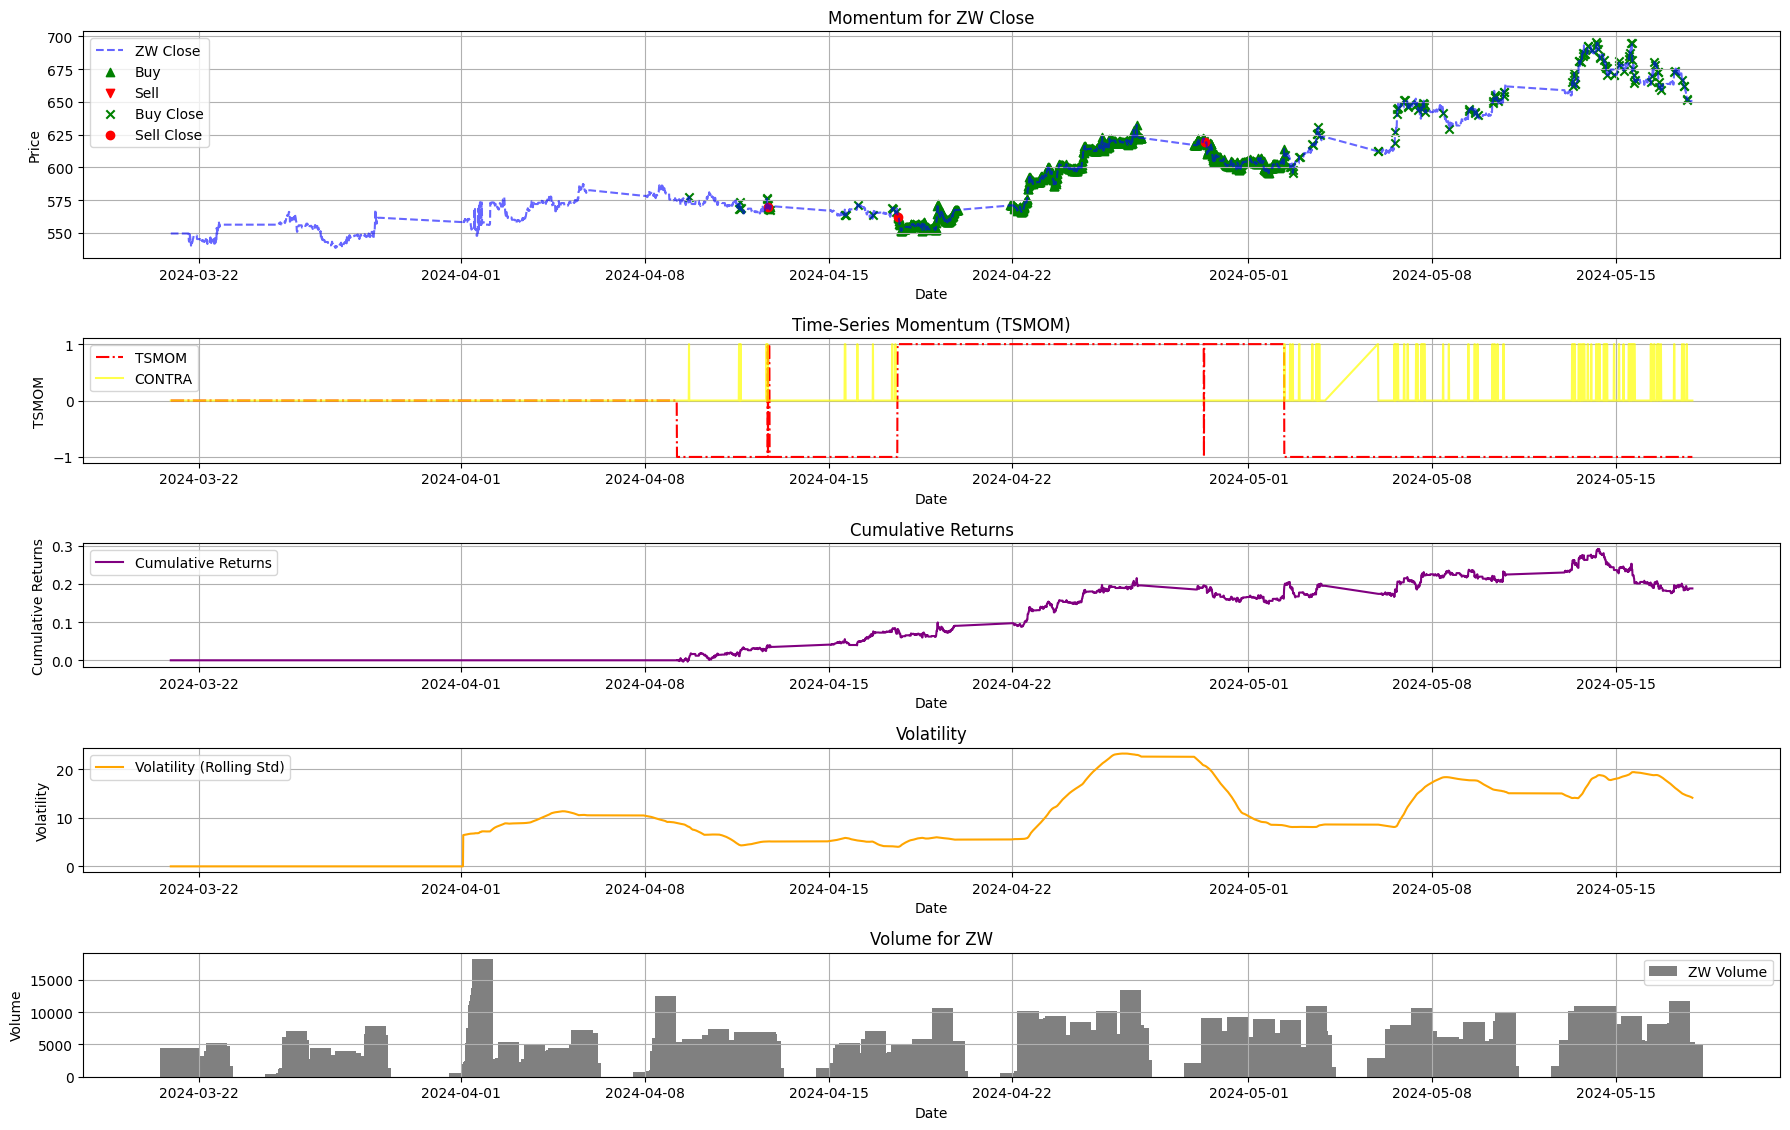

In [10]:
import matplotlib.pyplot as plt

backtest_df = futs_df[[f'{TARGET_FUT}_Close', f'{TARGET_FUT}_Volume']].copy()
backtest_df, stats_df = tsmom_backtest(backtest_df, f'{TARGET_FUT}_Close', lookback=BEST_WINDOW, contra_lookback=BEST_CONTRA, std_threshold=BEST_STD_THRESHOLD)
backtest_df['cRets'] = (1 + backtest_df['Ret']).cumprod() - 1
backtest_df['Volatility'] = backtest_df[f'{TARGET_FUT}_Close'].rolling(window=BEST_WINDOW).std().fillna(0.)
print(f"Cumulative returns from the strategy: {backtest_df['cRets'].iloc[-1]*100.:.02f}%")

plt.figure(figsize=(18, 12))
buy_signals = backtest_df[backtest_df['SB'] > 0]
sell_signals = backtest_df[backtest_df['SS'] < 0]
long_closed = backtest_df[backtest_df['Closed'] > 0]
short_closed = backtest_df[backtest_df['Closed'] < 0]

ax1 = plt.subplot2grid((12, 1), (0, 0), rowspan=3, colspan=1)
ax1.plot(backtest_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', color='blue', alpha=0.6, linestyle='--')
ax1.scatter(buy_signals.index, buy_signals[f'{TARGET_FUT}_Close'], color='green', marker='^', label='Buy')
ax1.scatter(sell_signals.index, sell_signals[f'{TARGET_FUT}_Close'], color='red', marker='v', label='Sell')
ax1.scatter(long_closed.index, long_closed[f'{TARGET_FUT}_Close'], color='green', marker='x', label='Buy Close')
ax1.scatter(short_closed.index, short_closed[f'{TARGET_FUT}_Close'], color='red', marker='o', label='Sell Close')

ax1.set_title(f'Momentum for {TARGET_FUT} Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

ax2 = plt.subplot2grid((12, 1), (3, 0), rowspan=2, colspan=1, sharex=ax1)
ax2.plot(backtest_df['TSMOM'], label='TSMOM', color='red', linestyle='-.')
ax2.plot(backtest_df['CONTRA'], label='CONTRA', color='yellow', linestyle='-', alpha=0.7)
ax2.set_title('Time-Series Momentum (TSMOM)')
ax2.set_xlabel('Date')
ax2.set_ylabel('TSMOM')
ax2.legend()
ax2.grid(True)

ax3 = plt.subplot2grid((12, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)
ax3.plot(backtest_df['cRets'], label='Cumulative Returns', color='purple')
ax3.set_title('Cumulative Returns')
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Returns')
ax3.legend()
ax3.grid(True)

ax4 = plt.subplot2grid((12, 1), (7, 0), rowspan=2, colspan=1, sharex=ax1)
ax4.plot(backtest_df['Volatility'], label='Volatility (Rolling Std)', color='orange')
ax4.set_title('Volatility')
ax4.set_xlabel('Date')
ax4.set_ylabel('Volatility')
ax4.legend()
ax4.grid(True)

ax5 = plt.subplot2grid((12, 1), (9, 0), rowspan=2, colspan=1, sharex=ax1)
ax5.bar(backtest_df.index, backtest_df[f'{TARGET_FUT}_Volume'], label=f'{TARGET_FUT} Volume', color='grey')
ax5.set_title(f'Volume for {TARGET_FUT}')
ax5.set_xlabel('Date')
ax5.set_ylabel('Volume')
ax5.legend()
ax5.grid(True)

plt.tight_layout()
plt.show()

# Test all Futs

In [11]:
all_metrics = pd.DataFrame()
for fut in FUTS:
    target=fut.replace("=F", "")

    fut_df = futs_df[[f"{target}_Close"]].copy()
    hl, _ = get_ou(fut_df, f"{target}_Close")
    hl = abs(hl) # trending strenght if negative
    stats_df = param_search_tsmom(fut_df, f'{target}_Close', initial_window=hl, window_min = hl // 8)

    all_metrics = pd.concat([all_metrics, stats_df.assign(Fut=target, Halflife=hl)], ignore_index=True)

mom_metrics = all_metrics[all_metrics["Cumulative_Returns"] > 0.001]
mom_metrics = mom_metrics.sort_values(by="Cumulative_Returns", ascending=False)
mom_metrics[["Cumulative_Returns", "Sharpe","Max_Drawdown","Window","Metric","Fut"]]

param_search_tsmom: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s]


,Cumulative_Returns,Sharpe,Max_Drawdown,Window,Metric,Fut
44,0.299544,-3.769400,-0.072372,40,Max Drawdown,PA
43,0.299544,-3.769400,-0.072372,40,Cumulative Returns,PA
42,0.299544,-3.769400,-0.072372,40,Sharpe,PA
14,0.258526,-8.810544,-0.044309,367,Max Drawdown,ZM
13,0.258526,-8.810544,-0.044309,367,Cumulative Returns,ZM
12,0.258526,-8.810544,-0.044309,367,Sharpe,ZM
19,0.219052,-7.984479,-0.055410,53,Cumulative Returns,LE
18,0.219052,-7.984479,-0.055410,53,Sharpe,LE
1,0.212961,-7.070691,-0.053238,116,Cumulative Returns,ZC
0,0.212961,-7.070691,-0.053238,116,Sharpe,ZC
